# CIS 4780 - Assignment 1

Name: Kyle Lukaszek

ID: 1113798

Due: 10/5/2023

## Import Dependencies

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score

## Define PyTorch Z-Score Normalization Function

In [22]:
## Simple implementation based on sklearn.preprocessing.StandardScaler
class ZScoreNormalizer:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        # Calculate the mean and standard deviation along dim 0 (columns)
        self.mean = torch.mean(data, dim=0)
        self.std = torch.std(data, dim=0)

    def transform(self, data):
        if self.mean is None or self.std is None:
            raise ValueError("Not fitted yet. Call fit() before transform()")
        
        # z = (X - mean) / std
        normalized_data = (data - self.mean) / self.std
        return normalized_data

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

## Part 1 - KNN Implementation

### Define KNN Classifier Class

In [23]:
class KNNClassifier:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = torch.tensor(X_train)
        self.y_train = torch.tensor(y_train)

    def predict(self, X_test, k):
        y_pred = []

        for x_test in X_test:
            # Calculate euclidian distances from the test point to all training points
            distances = torch.norm(self.X_train - torch.tensor(x_test), dim=1)

            # Sort euclidean distances and get the indices of the k-nearest neighbors
            indices = torch.argsort(distances)[:k]

            # Get the labels of the k-nearest neighbors
            neighbors_labels = self.y_train[indices]

            # Predict/classify the label by taking the majority vote (i.e. the sign of the sum)
            prediction = torch.sign(torch.sum(neighbors_labels))

            # Append the prediction/classification to the list of predictions
            y_pred.append(prediction.item())

        return y_pred

### Define KNN K-fold Cross Validation Function

In [55]:
def knn_k_fold_cross_validation(X, y, k_values, n_folds=10):
    # Initialize lists to store accuracy scores for training and testing
    train_accuracies = []
    test_accuracies = []
    train_errors = []
    test_errors = []

    # Initialize K-fold cross-validation using sci-kit learn's KFold class
    # It is better to shuffle the data before splitting it into folds
    kf = KFold(n_splits=n_folds, shuffle=True)

    # Loop through different K values
    for k in k_values:
        fold_accuracies_train = []
        fold_accuracies_test = []

        # Used in part 4 of the assignment
        fold_errors_train = []
        fold_errors_test = []

        # Loop through different folds of the data
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Initialize and fit the KNN classifier on the training data
            knn = KNNClassifier()
            knn.fit(X_train, y_train)

            # Calculate accuracy for this fold using the current K value
            train_predictions = knn.predict(X_train, k)
            test_predictions = knn.predict(X_test, k)

            # Calculate the accuracy for this fold using sklearn's accuracy_score function
            train_accuracy = accuracy_score(y_train, train_predictions)
            test_accuracy = accuracy_score(y_test, test_predictions)

            # Calculate errors for this fold (used in part 4 of the assignment)
            train_err = 1 - train_accuracy
            test_err = 1 - test_accuracy

            # Append the accuracy for this fold to the list of accuracies
            fold_accuracies_train.append(train_accuracy)
            fold_accuracies_test.append(test_accuracy)

            # Append the error for this fold to the list of errors (used in part 4 of the assignment)
            fold_errors_train.append(train_err)
            fold_errors_test.append(test_err)

        # Calculate the average accuracy over all folds for this K value
        avg_train_accuracy = np.mean(fold_accuracies_train)
        avg_test_accuracy = np.mean(fold_accuracies_test)

        # Calculate the average error over all folds for this K value (used in part 4 of the assignment)
        avg_train_error = np.mean(fold_errors_train)
        avg_test_error = np.mean(fold_errors_test)

        # Append the average accuracy for this K value to the list of accuracies
        train_accuracies.append(avg_train_accuracy)
        test_accuracies.append(avg_test_accuracy)

        # Append the average error for this K value to the list of errors (used in part 4 of the assignment)
        train_errors.append(avg_train_error)
        test_errors.append(avg_test_error)

    # Return a dictionary containing the training and testing accuracies for each K value, as well as the training and testing errors (used in part 4 of the assignment)
    return {
        "train_acc": train_accuracies,
        "test_acc": test_accuracies,
        "train_err": train_errors,
        "test_err": test_errors
    }

### Load Data And Run KNN Code

In [56]:
input_file = 'KNNClassifierInput.csv'
output_file = 'KNNClassifierOutput.csv'

# Load input data from the input file using Pandas
input_df = pd.read_csv(input_file, header=0)

# Load output data from the output file using Pandas
output_df = pd.read_csv(output_file)

# Remove empty columns from output data
output_df = output_df.dropna(axis=1)

# Convert input data to np array
X = input_df[['Input 1', 'Input 2']].values

# Convert output data to np array and squeeze it to a 1D array
y = output_df.values.squeeze()

# Define the range of K values to test
k_values = list(range(1, 31))  # Test K from 1 to 30

# Perform 10-fold cross-validation and get results as a dictionary
results = knn_k_fold_cross_validation(X, y, k_values, n_folds=10)

train_acc = results["train_acc"]
test_acc = results["test_acc"]
train_err = results["train_err"]
test_err = results["test_err"]

# Select the best K based on testing accuracy
best_k = k_values[np.argmax(test_acc)]
print(f"Best K Value: {best_k}")
print(f"Test Accuracy with Best K Value: {max(test_acc) * 100:.2f}%")

Best K Value: 15
Test Accuracy with Best K Value: 97.60%


### Plot Results

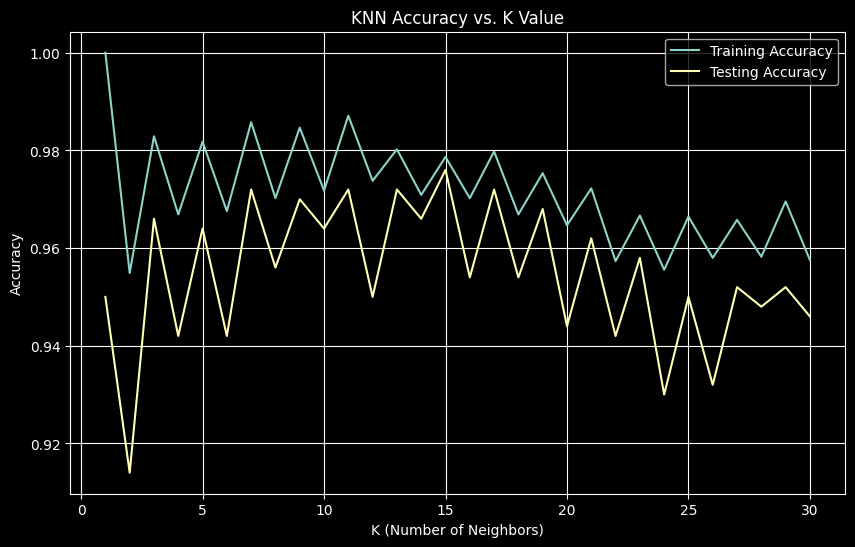

In [57]:
# Plot the accuracy for different K values
plt.figure(figsize=(10, 6))
plt.plot(k_values, results['train_acc'], label='Training Accuracy')
plt.plot(k_values, results['test_acc'], label='Testing Accuracy')
plt.title('KNN Accuracy vs. K Value')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### K-Value Analysis

Write analysis here.

## Part 2: Linear Regression (Ridge)

Make sure that the Z-Score normalization function is defined and ran before running the following code.

This function can be found in the "Define PyTorch Z-Score Normalization Function" section at the top of the notebook.

**If you ran all cells in order, you should be fine.**

### Define Ridge Regression Class

In [ ]:
class RidgeRegression(nn.Module):
    def __init__(self, input_dim):
        # Initialize the parent class (nn.Module)
        super(RidgeRegression, self).__init__()
        # Define the linear layer
        self.linear = nn.Linear(input_dim, 1)
    
    # Forward pass
    def forward(self, x):
        return self.linear(x)

### Define Ridge Regression K-fold Cross Validation Function

In [ ]:
def lr_k_fold_cross_validation(X, y, model, criterion, optimizer, num_epochs=100, lambda_val=0.0, n_folds=5):
    # Initialize lists to store accuracy scores for training and testing
    train_losses = []  # To store training losses for each fold
    test_losses = []   # To store testing losses for each fold
    r2_scores = []     # To store R2 scores for each fold
    mse_scores = []    # To store Mean Squared Error scores for each fold

    # Initialize K-fold cross-validation using sci-kit learn's KFold class
    # It is better to shuffle the data before splitting it into folds
    kf = KFold(n_splits=n_folds, shuffle=True)

    # Loop through different folds of the data
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Set the model to training mode
        model.train()
            
        # Zero out the gradients in the optimizer
        optimizer.zero_grad()

        # Training Loop
        for epoch in range(num_epochs):
            
            # Forward pass: compute predictions
            outputs = model(X_train)
            
            # Calculate the loss
            loss = criterion(outputs, y_train)
            
            # Add L2 regularization term to the loss
            l2_reg = lambda_val * torch.sum(model.linear.weight ** 2)
            loss += l2_reg
            
            # Backward pass: compute gradients
            loss.backward()

            """
            Note: 
            Gradient clipping prevents a NaN error due to exploding gradients in my case, I am not sure if there is an error in my implementation but I thought I should mention it.
            I could have used a smaller learning rate for the optimizer but I found that gradient clipping results in more consistent results.
            """
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update the model's parameters
            optimizer.step()

        # Evaluation
        # Set the model to evaluation mode (no gradient computation)
        model.eval()
        
        with torch.no_grad():
            # Compute predictions on the training and testing data
            train_outputs = model(X_train)
            test_outputs = model(X_test)

            # Calculate training and testing losses
            train_loss = criterion(train_outputs, y_train)
            test_loss = criterion(test_outputs, y_test)
            
            # Calculate R2 score and Mean Squared Error for testing data
            r2 = r2_score(y_test, test_outputs)
            mse = mean_squared_error(y_test, test_outputs)

        # Store the results for this fold
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        r2_scores.append(r2)
        mse_scores.append(mse)

    # Calculate average results over all folds
    avg_train_loss = np.mean(train_losses)
    avg_test_loss = np.mean(test_losses)
    avg_r2_score = np.mean(r2_scores)
    avg_mse_score = np.mean(mse_scores)

    return {
        'avg_train_loss': avg_train_loss,
        'avg_test_loss': avg_test_loss,
        'avg_r2_score': avg_r2_score,
        'avg_mse_score': avg_mse_score
    }

### Load Data And Run Linear Regression Code

In [ ]:
input_file = 'LinearRegression.csv'
target_file = 'LinearRegressionTarget.csv'

# Load the input data
input_data_df = pd.read_csv(input_file)

# Load the target data
target_data_df = pd.read_csv(target_file)

# Get input data to a PyTorch tensor
X = torch.tensor(input_data_df.values, dtype=torch.float32)

# Get target values as a PyTorch tensor
y = torch.tensor(target_data_df.values, dtype=torch.float32)

# Normalize input data using custom ZScoreNormalizer class
input_normalizer = ZScoreNormalizer()
X = input_normalizer.fit_transform(X)

# Normalize target data using custom ZScoreNormalizer class
target_normalizer = ZScoreNormalizer()
y = target_normalizer.fit_transform(y)

# Initialize hyperparameters
input_dim = X.shape[1]  # Adjust this according to your dataset
num_epochs = 100

# Lambda values from [0, 250]
lambda_values = list(range(0, 251))
results = []

# Perform Ridge Regression with cross-validation for different lambda values
for lambda_val in lambda_values:
    model = RidgeRegression(input_dim)

    # Define the loss function
    criterion = nn.MSELoss()

    """ 
    Note: 
    I used a learning rate of 0.01 because I used gradient clipping to prevent exploding gradients (see the lr_k_fold_cross_validation function above).
    I messed around with using a smaller learning rate (e.g. 0.001) and no gradient clipping but I found that this resulted in a lower R2 score and larger avg losses.
    Therefore, I decided to use a larger learning rate with gradient clipping to get the best results with my implementation.
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    cv_results = lr_k_fold_cross_validation(X, y, model, criterion, optimizer, num_epochs, lambda_val, num_folds=5)
    results.append((lambda_val, cv_results))

# Find the lambda with the best average R2 score
best_lambda, best_results = max(results, key=lambda x: x[1]['avg_r2_score'])

# Print lambda results for lambda=0
print("Results for lambda=0:")
print(results[0][1]) 

# Print lambda results for best lambda
print(f"\nBest lambda: {best_lambda}")
print("Results for best lambda:")
print(best_results)

### Plot Ridge Regression R2 Results and MSE

In [ ]:
# Plot R2 scores for different lambda values
r2_scores = [result[1]['avg_r2_score'] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, r2_scores)
plt.title('R2 Score vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Average R2 Score')
plt.grid(True)
plt.show()

# Plot MSE scores for different lambda values
mse_scores = [result[1]['avg_mse_score'] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, mse_scores)
plt.title('MSE Score vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Average MSE Score')
plt.grid(True)
plt.show()

### Best Lambda Observation

Write analysis here.

## Part 3: Logistic Regression

Make sure that the Z-Score normalization function is defined and ran before running the following code.

This function can be found in the "Define PyTorch Z-Score Normalization Function" section at the top of the notebook.

**If you ran all cells in order, you should be fine.**

### Define Logistic Regression Class

In [25]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        # Define the linear layer followed by a sigmoid activation function since this is a logistic regression model
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Define the forward pass of the model
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

### Define Logistic Regression Training Function

In [26]:
def train_logistic_regression_model(X_train, y_train, num_epochs=100, learning_rate=0.01):
    input_size = X_train.shape[1]

    # Create and initialize the model with the same data type
    model = LogisticRegressionModel(input_size)
    model.to(torch.float32)  # Set the model's data type to match the input data

    # Ensure consistent data types for model parameters
    for param in model.parameters():
        param.data = param.data.to(torch.float32)

    # Initialize optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Create a DataLoader for training data
    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        # Iterate through batches of training data
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    return model

### Define Logistic Regression Evaluation Function

In [33]:
def eval_logistic_regression_model(model, X_test, y_test, average='binary'):
    # Set the model to evaluation mode
    model.eval()
    
    # Create a DataLoader for test data
    test_data = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        # Iterate through batches of test data and get predictions
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and F1 score
    acc = accuracy_score(all_labels, all_predictions)

    # Note: I use the 'average' parameter because for part 4 of the assignment, we are using a multi-class dataset.
    # Note 2: By default, the average parameter is set to 'binary' which is what we want for part 3 of the assignment.
    f1 = f1_score(all_labels, all_predictions, average=average)

    # Calculate error rate (used in part 4)
    err = 1 - acc

    return acc, f1, err

### Define Logistic Regression K-fold Cross Validation Function

In [34]:
def logistic_regression_k_fold_cross_validation(X, y, n_folds=10, num_epochs=100, learning_rate=0.01, average='binary'):

    # Check if average parameter is valid based on the documentation for sklearn's f1_score function
    valid = ['binary', 'micro', 'macro', 'weighted', 'samples', None]
    if average not in valid:
        raise ValueError(f"Invalid average parameter. Expected one of {valid}, got {average}")

    # Initialize K-fold cross-validation using sci-kit learn's KFold class
    # It is better to shuffle the data before splitting it into folds
    kf = KFold(n_splits=n_folds, shuffle=True)

    # Initialize lists to store accuracy and f1 scores for training and testing
    train_acc = []
    test_acc = []
    train_f1 = []
    test_f1 = []
    error_train = []
    error_test = []

    # Loop through different folds of the data and train then evaluate the model, store the results for each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Ensure consistent data types for input data due to runtime error that occured due to mat1 and mat2 type mismatch
        X_train = X_train.to(torch.float32)
        X_test = X_test.to(torch.float32)
        y_train = y_train.to(torch.int64)
        y_test = y_test.to(torch.int64)

        # Train and evaluate the model
        model = train_logistic_regression_model(X_train, y_train, num_epochs, learning_rate)
        acc_train, f1_train, err_train = eval_logistic_regression_model(model, X_train, y_train, average=average)
        acc_test, f1_test, err_test = eval_logistic_regression_model(model, X_test, y_test, average=average)
        
        # Save the results for this fold
        train_acc.append(acc_train)
        test_acc.append(acc_test)
        train_f1.append(f1_train)
        test_f1.append(f1_test)

        # Append error rate for this fold (used in part 4)
        error_train.append(err_train)
        error_test.append(err_test)

    # Return the results for all folds as a dictionary
    return {
        "train_acc": train_acc, 
        "test_acc": test_acc, 
        "train_f1": train_f1, 
        "test_f1": test_f1,
        "train_err": error_train,
        "test_err": error_test
        }

### Load Data And Run Logistic Regression Code

In [19]:
# Load the data using Pandas, I named the columns because the first column was being interpreted as strings so I needed to convert it to numeric
data = pd.read_csv("LogisticRegression.csv", names=["Input 1", "Input 2", "Input 3", "Input 4", "Input 5", "Input 6", "Input 7", "Input 8", "Label"])

# Get input data from all rows and all columns except the last column (8 input features)
X = data.iloc[:, :-1]

# For some reason, the first column is mostly comprised of 1s and 0s but there are some missing values that are represented as "Other"
# I decided to replace these missing values with 0
X["Input 1"] = X["Input 1"].replace("Other", 0)

# Convert input 1 column to int64
X['Input 1'] = X['Input 1'].astype('int64')

# Convert the input data to a numpy array
X = X.values

# Get all rows of the last column as a numpy array (labels)
y = data.iloc[:, -1:].values

# Squeeze the array to remove the extra dimension
y = np.squeeze(y)

# Transform to PyTorch tensors
X = torch.from_numpy(X)
y = torch.from_numpy(y)

# Normalize input data using custom ZScoreNormalizer class
input_normalizer = ZScoreNormalizer()
X = input_normalizer.fit_transform(X)

# Perform 10-fold cross-validation
results = logistic_regression_k_fold_cross_validation(X, y, n_folds=10, learning_rate=0.01)

# Get results for training and testing
train_acc = results["train_acc"]
test_acc = results["test_acc"]
train_f1 = results["train_f1"]
test_f1 = results["test_f1"]

# Print results
print("Accuracy (Training) Mean:", np.mean(train_acc))
print("Accuracy (Testing) Mean:", np.mean(test_acc))
print("Accuracy (Training) Standard Deviation:", np.std(train_acc))
print("Accuracy (Testing) Standard Deviation:", np.std(test_acc))
print("F1 Score (Training) Mean:", np.mean(train_f1))
print("F1 Score (Testing) Mean:", np.mean(test_f1))
print("F1 Score (Training) Standard Deviation:", np.std(train_f1))
print("F1 Score (Testing) Standard Deviation:", np.std(test_f1))
print("Highest Accuracy (Testing):", max(test_acc))
print("Lowest Accuracy (Testing):", min(test_acc))
print("Highest F1 Score (Testing):", max(test_f1))
print("Lowest F1 Score (Testing):", min(test_f1))

Accuracy (Training) Mean: 0.9601855555555556
Accuracy (Testing) Mean: 0.9601
Accuracy (Training) Standard Deviation: 0.00023428641329959092
Accuracy (Testing) Standard Deviation: 0.0019209372712298447
F1 Score (Training) Mean: 0.7276012311256086
F1 Score (Testing) Mean: 0.7269346855063819
F1 Score (Training) Standard Deviation: 0.0014216338483061604
F1 Score (Testing) Standard Deviation: 0.013107845337368954
Highest Accuracy (Testing): 0.9642
Lowest Accuracy (Testing): 0.9577
Highest F1 Score (Testing): 0.7541208791208792
Lowest F1 Score (Testing): 0.7088607594936708


### Results (Getting these took ~20mins on a 6-Core 4.9GHz i5-9600k)

Accuracy (Training) Mean: 0.9601855555555556
Accuracy (Testing) Mean: 0.9601
Accuracy (Training) Standard Deviation: 0.00023428641329959092
Accuracy (Testing) Standard Deviation: 0.0019209372712298447
F1 Score (Training) Mean: 0.7276012311256086
F1 Score (Testing) Mean: 0.7269346855063819
F1 Score (Training) Standard Deviation: 0.0014216338483061604
F1 Score (Testing) Standard Deviation: 0.013107845337368954
Highest Accuracy (Testing): 0.9642
Lowest Accuracy (Testing): 0.9577
Highest F1 Score (Testing): 0.7541208791208792
Lowest F1 Score (Testing): 0.7088607594936708

### Accuracy Vs. F1 Score (F-Measure)

Write analysis here.

## Part 4: K-Nearsest Neighbor Classifier VS Logistic Regression

It is important to run the KNN and Logistic Regression class definition cells before running this cells.

It is also important to run all function definition cells in part 1 and part 3 before running the following cells.

If you do not do this, the following cell will not work. 

**If you ran all cells in order, you should be fine.**

### KNN Test

The following code is the same as the code in part 1.

Dataset has 500 entries, 2 inputs, and the output can be -1 or 1.

In [74]:
input_file = 'KNNClassifierInput.csv'
output_file = 'KNNClassifierOutput.csv'

# Load input data from the input file using Pandas
input_df = pd.read_csv(input_file, header=0)

# Load output data from the output file using Pandas
output_df = pd.read_csv(output_file)

# Remove empty columns from output data
output_df = output_df.dropna(axis=1)

# Convert input data to np array
X = input_df[['Input 1', 'Input 2']].values

# Convert output data to np array and squeeze it to a 1D array
y = output_df.values.squeeze()

# Define the range of K values to test
k_values = list(range(1, 31))  # Test K from 1 to 30

# Perform 10-fold cross-validation and get results as a dictionary
knn_results = knn_k_fold_cross_validation(X, y, k_values, n_folds=10)

knn_train_acc = knn_results["train_acc"]
knn_test_acc = knn_results["test_acc"]
knn_train_err = knn_results["train_err"]
knn_test_err = knn_results["test_err"]

# Select the best K based on testing accuracy
best_k = k_values[np.argmax(knn_test_acc)]
print(f"Best K Value: {best_k}")
print(f"Test Accuracy with Best K Value: {max(knn_test_acc) * 100:.2f}%")

# Print results
print("\nAccuracy (Training) Mean:", np.mean(knn_train_acc))
print("Accuracy (Testing) Mean:", np.mean(knn_test_acc))
print("Accuracy (Training) Standard Deviation:", np.std(knn_train_acc))
print("Accuracy (Testing) Standard Deviation:", np.std(knn_test_acc))

print("\nHighest Accuracy (Testing):", max(knn_test_acc))
print("Highest Accuracy (Training):", max(knn_train_acc))
print("Lowest Accuracy (Testing):", min(knn_test_acc))
print("Lowest Accuracy (Training):", min(knn_train_acc))

print("\nError Rate (Training) Mean:", np.mean(knn_train_err))
print("Error Rate (Testing) Mean:", np.mean(knn_test_err))
print("Error Rate (Training) Standard Deviation:", np.std(knn_train_err))
print("Error Rate (Testing) Standard Deviation:", np.std(knn_test_err))

print("\nHighest Error Rate (Testing):", max(knn_test_err))
print("Highest Error Rate (training):", max(knn_test_err))
print("Lowest Error Rate (Testing):", min(knn_test_err))
print("Lowest Error Rate (Training):", min(knn_test_err))

Best K Value: 9
Test Accuracy with Best K Value: 97.60%

Accuracy (Training) Mean: 0.9710370370370369
Accuracy (Testing) Mean: 0.9569333333333333
Accuracy (Training) Standard Deviation: 0.010644472795652848
Accuracy (Testing) Standard Deviation: 0.014345576166733643

Highest Accuracy (Testing): 0.9760000000000002
Highest Accuracy (Training): 1.0
Lowest Accuracy (Testing): 0.914
Lowest Accuracy (Training): 0.9535555555555556

Error Rate (Training) Mean: 0.02896296296296296
Error Rate (Testing) Mean: 0.04306666666666669
Error Rate (Training) Standard Deviation: 0.010644472795652856
Error Rate (Testing) Standard Deviation: 0.014345576166733614

Highest Error Rate (Testing): 0.08600000000000001
Highest Error Rate (training): 0.08600000000000001
Lowest Error Rate (Testing): 0.02400000000000002
Lowest Error Rate (Training): 0.02400000000000002


### Logistic Regression Test

In [77]:
# Convert input data and labels to PyTorch tensors
X = input_df[['Input 1', 'Input 2']].values
y = output_df.values.squeeze()

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# It is important to normalize our input data before training the logistic regression model
input_normalizer = ZScoreNormalizer()
X = input_normalizer.fit_transform(X)

# Perform 10-fold cross-validation
# Note: I used a learning rate of 0.0001 because I found that this resulted in the best results with this dataset
lr_results = logistic_regression_k_fold_cross_validation(X, y, n_folds=10, learning_rate=0.0001, average='weighted')

# Get results for training and testing
lr_train_acc = lr_results["train_acc"]
lr_test_acc = lr_results["test_acc"]
lr_train_f1 = lr_results["train_f1"]
lr_test_f1 = lr_results["test_f1"]
lr_err_train = lr_results["train_err"]
lr_err_test = lr_results["test_err"]

# Print results
print("Accuracy (Training) Mean:", np.mean(lr_train_acc))
print("Accuracy (Testing) Mean:", np.mean(lr_test_acc))
print("Accuracy (Training) Standard Deviation:", np.std(lr_train_acc))
print("Accuracy (Testing) Standard Deviation:", np.std(lr_test_acc))

print("\nHighest Accuracy (Testing):", max(lr_test_acc))
print("Highest Accuracy (Training):", max(lr_train_acc))
print("Lowest Accuracy (Testing):", min(lr_test_acc))
print("Lowest Accuracy (Training):", min(lr_train_acc))

print("\nF1 Score (Training) Mean:", np.mean(lr_train_f1))
print("F1 Score (Testing) Mean:", np.mean(lr_test_f1))
print("F1 Score (Training) Standard Deviation:", np.std(lr_train_f1))
print("F1 Score (Testing) Standard Deviation:", np.std(lr_test_f1))

print("\nHighest F1 Score (Testing):", max(lr_test_f1))
print("Highest F1 Score (Training):", max(lr_train_f1))
print("Lowest F1 Score (Testing):", min(lr_test_f1))
print("Lowest F1 Score (Training):", min(lr_train_f1))

print("\nError Rate (Training) Mean:", np.mean(lr_err_train))
print("Error Rate (Testing) Mean:", np.mean(lr_err_test))
print("Error Rate (Training) Standard Deviation:", np.std(lr_err_train))
print("Error Rate (Testing) Standard Deviation:", np.std(lr_err_test))

print("\nHighest Error Rate (Testing):", max(lr_err_test))
print("Highest Error Rate (Training):", max(lr_err_train))
print("Lowest Error Rate (Testing):", min(lr_err_test))
print("Lowest Error Rate (Training):", min(lr_err_train))

Accuracy (Training) Mean: 0.17688888888888887
Accuracy (Testing) Mean: 0.178
Accuracy (Training) Standard Deviation: 0.12283563242232522
Accuracy (Testing) Standard Deviation: 0.12631706139710502

Highest Accuracy (Testing): 0.42
Highest Accuracy (Training): 0.4022222222222222
Lowest Accuracy (Testing): 0.02
Lowest Accuracy (Training): 0.024444444444444446

F1 Score (Training) Mean: 0.1797902669359141
F1 Score (Testing) Mean: 0.18331576772471442
F1 Score (Training) Standard Deviation: 0.09117865649963713
F1 Score (Testing) Standard Deviation: 0.10936426075289384

Highest F1 Score (Testing): 0.43448275862068964
Highest F1 Score (Training): 0.31403446226975645
Lowest F1 Score (Testing): 0.03259259259259259
Lowest F1 Score (Training): 0.03966457023060796

Error Rate (Training) Mean: 0.8231111111111111
Error Rate (Testing) Mean: 0.8220000000000001
Error Rate (Training) Standard Deviation: 0.12283563242232522
Error Rate (Testing) Standard Deviation: 0.126317061397105

Highest Error Rate (Te

### Graph Results of KNN and Logistic Regression

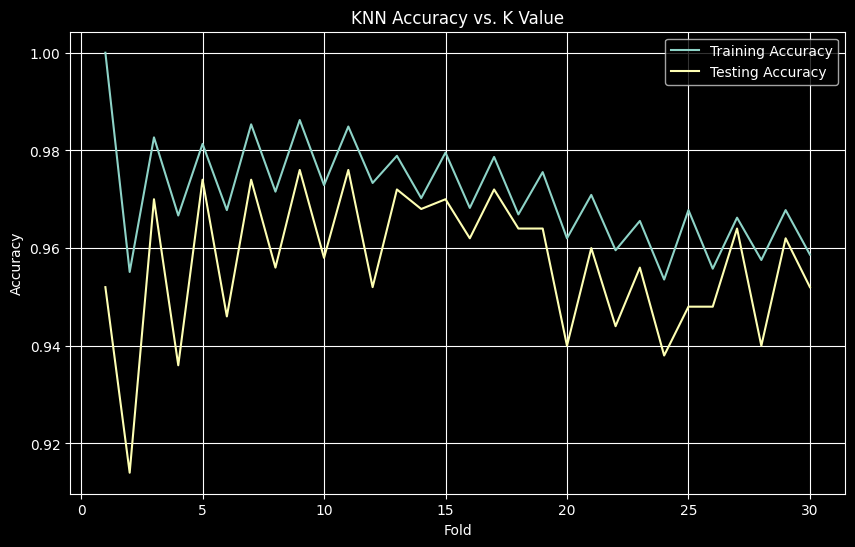

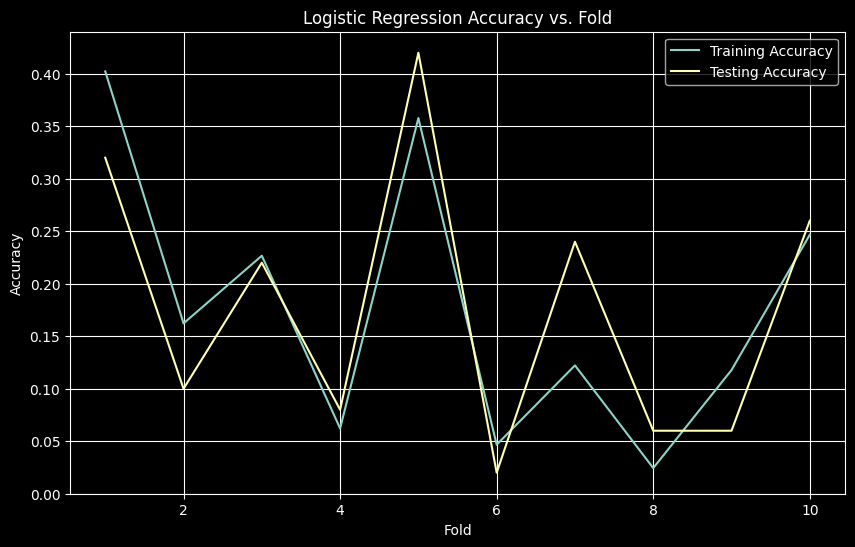

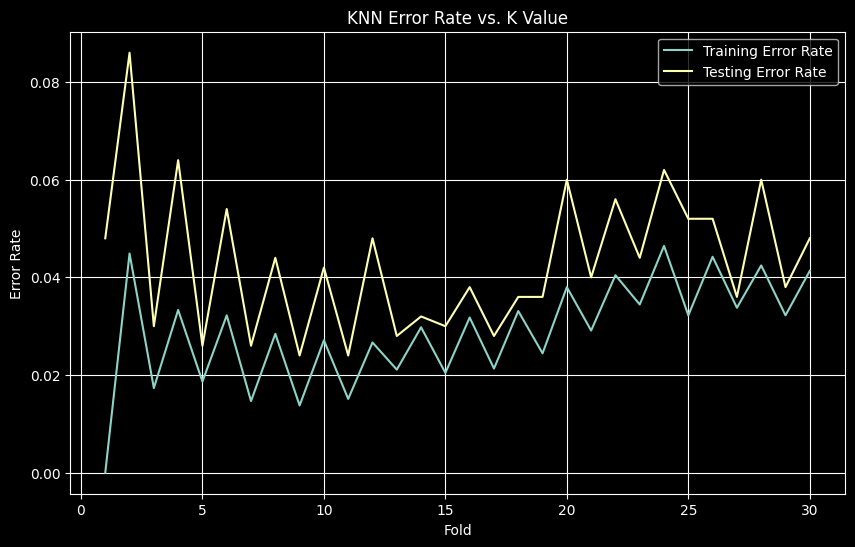

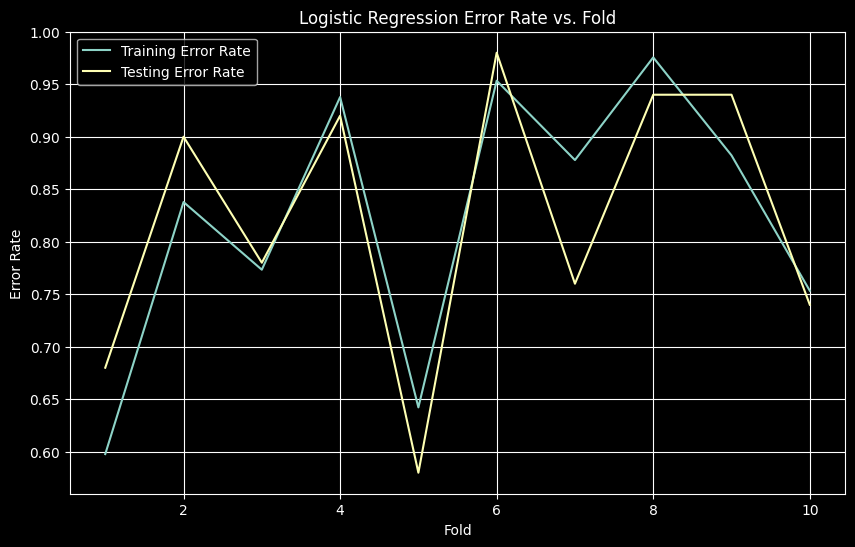

In [79]:
# Graph accuracy for KNN per K value
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_train_acc, label='Training Accuracy')
plt.plot(k_values, knn_test_acc, label='Testing Accuracy')
plt.title('KNN Accuracy vs. K Value')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Graph accuracy for logistic regression per fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), lr_train_acc, label='Training Accuracy')
plt.plot(range(1, 11), lr_test_acc, label='Testing Accuracy')
plt.title('Logistic Regression Accuracy vs. Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Graph error rate for KNN per K value
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_train_err, label='Training Error Rate')
plt.plot(k_values, knn_test_err, label='Testing Error Rate')
plt.title('KNN Error Rate vs. K Value')
plt.xlabel('Fold')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

# Graph error rate for logistic regression per fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), lr_err_train, label='Training Error Rate')
plt.plot(range(1, 11), lr_err_test, label='Testing Error Rate')
plt.title('Logistic Regression Error Rate vs. Fold')
plt.xlabel('Fold')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()